
### Търсене и извличане на информация. Приложение на дълбоко машинно обучение
### Стоян Михов
### Зимен семестър 2025/2026

## Упражнение 4

За да работи програмата трябва корпуса от публицистични текстове за Югоизточна Европа,
да се намира разархивиран в наддиректорията, в която е програмата (виж упражнение 2).

Преди да се стартира програмата е необходимо да се активира съответното обкръжение с командата:
conda activate tii

In [26]:
import nltk
from nltk.corpus import PlaintextCorpusReader
import sys
import random
import math
import matplotlib.pyplot as plt

corpus_root = '../JOURNALISM.BG/C-MassMedia'
myCorpus = PlaintextCorpusReader(corpus_root, '.*\.txt')

<>:9: SyntaxWarning: invalid escape sequence '\.'
<>:9: SyntaxWarning: invalid escape sequence '\.'
C:\Users\Rumen\AppData\Local\Temp\ipykernel_18708\2910818520.py:9: SyntaxWarning: invalid escape sequence '\.'
  myCorpus = PlaintextCorpusReader(corpus_root, '.*\.txt')


In [27]:
class progressBar:
    def __init__(self, barWidth=80):
        self.barWidth = barWidth
        self.period = None

    def start(self, count):
        self.item = 0
        self.period = int(count / self.barWidth)
        sys.stdout.write("["+(" " * self.barWidth)+"]\n")
        sys.stdout.flush()
        sys.stdout.write("[") # for jupyter
        sys.stdout.flush() # for jupyter
        # sys.stdout.write("\b" * (self.barWidth+1)) # for terminal

    def tick(self):
        if self.item>0 and self.item % self.period == 0:
            sys.stdout.write("#")
            sys.stdout.flush()
        self.item += 1

    def stop(self):
        sys.stdout.write("]\n")

In [28]:
def splitSentCorpus(fullSentCorpus, testFraction = 0.1):
    random.seed(42)
    random.shuffle(fullSentCorpus)
    testCount = int(len(fullSentCorpus) * testFraction)
    testSentCorpus = fullSentCorpus[:testCount]
    trainSentCorpus = fullSentCorpus[testCount:]
    return testSentCorpus, trainSentCorpus

In [29]:
startToken = '<START>'
endToken = '<END>'
unkToken = '<UNK>'

In [30]:
fullSentCorpus = [ [startToken] + [w.lower() for w in sent] + [endToken] for sent in myCorpus.sents()]
testDevSentCorpus, trainSentCorpus = splitSentCorpus(fullSentCorpus)
testSentCorpus, devSentCorpus = splitSentCorpus(testDevSentCorpus, testFraction = 0.5)

$$
\Pr[x_1 x_2 \ldots x_n] = \Pr[x_1 \mid \varepsilon] \Pr[x_2 \mid x_1] \ldots \Pr[x_n \mid x_1 x_2 \ldots x_{n-1}] \Pr[\$ \mid x_1 x_2 \ldots x_n].
$$


$$
\hat{P}^{k}_{\text{MLE}}[x \mid x_1 x_2 \ldots x_m] =
\begin{cases}
\dfrac{\#(x_1 x_2 \ldots x_m x)}{\#(x_1 x_2 \ldots x_m)}, & \text{if } m = k - 1, \\[1.2em]
\dfrac{\#(\hat{ }x_1 x_2 \ldots x_m x)}{\#(\hat{    }x_1 x_2 \ldots x_m)}, & \text{if } m < k - 1,
\end{cases}
$$

Изглаждане:
$$
\hat{P}^{k}_{\text{int}}[x \mid x_1 x_2 \ldots x_m] 
= \lambda \hat{P}^{k}_{\text{MLE}}[x \mid x_1 x_2 \ldots x_m] 
+ (1 - \lambda) \hat{P}^{k-1}_{\text{int}}[x \mid x_2 x_3 \ldots x_m]
$$

Използваме езиков модел $M_d$, извлечен от документа $d$
$$
\hat{P}_{\text{MLE}}[t \mid \varepsilon; M_d] = \frac{\mathrm{tf}_{t,d}}{L_d}
$$

In [31]:
class MarkovModel:
    def __init__(self, corpus, K, dictionaryLimit = 50000, startToken = '<START>', endToken = '<END>', unkToken = '<UNK>'):
        self.K = K
        self.startToken = startToken
        self.endToken = endToken
        self.unkToken = unkToken
        self.kgrams ={}
        self.extractMonograms(corpus,dictionaryLimit)
        for k in range(2,K+1):
            self.extractKgrams(corpus,k)
        self.Tc = {}
        for context in self.kgrams:
            self.Tc[context] = sum( self.kgrams[context][v] for v in self.kgrams[context])

    def extractMonograms(self, corpus,limit):
        pb = progressBar()
        pb.start(len(corpus))
        dictionary = {}
        for sent in corpus:
            pb.tick()
            for w in sent[1:]:
                if w not in dictionary:
                    dictionary[w] = 0
                dictionary[w] += 1
        L = sorted([(w,dictionary[w]) for w in dictionary], key = lambda x: x[1] , reverse=True)
        if limit > len(L): limit = len(L)
        mono = { w:c for (w,c) in L[:limit] }
        sumUnk = sum( c for (_,c) in L[limit:] )
        mono[self.unkToken] = sumUnk
        self.kgrams[tuple()] = mono
        pb.stop()

    def substituteUnkownWords(self, sentence):
        return [sentence[0]] + [ w if w in self.kgrams[tuple()] else self.unkToken for w in sentence[1:]]

    def extractKgrams(self, corpus, k):
        pb = progressBar()
        pb.start(len(corpus))
        for s in corpus:
            pb.tick()
            sent = self.substituteUnkownWords(s)
            for i in range(k-1,len(sent)):
                w = sent[i]
                context = tuple(sent[i-k+1:i])
                if context not in self.kgrams: self.kgrams[context] = {}
                if w not in self.kgrams[context]: self.kgrams[context][w] = 0
                self.kgrams[context][w] += 1
        pb.stop()

    def probMLE(self, w ,context):
        if context not in self.kgrams:
            return 0.0
        elif w not in self.kgrams[context]:
            return 0.0
        else:
            return self.kgrams[context][w] / self.Tc[context]

    def prob(self, w, context, alpha):
        if len(context) > 0:
            return alpha * self.probMLE(w,context) + (1-alpha) * self.prob(w,context[1:],alpha)
        else:
            return self.probMLE(w,context)

    def sentenceLogProbability(self, s, alpha):
        sent = self.substituteUnkownWords(s)
        return sum(math.log(self.prob(sent[i],tuple(sent[max(0,i-self.K+1):i]),alpha),2) for i in range(1,len(sent)))

    def bestContinuation(self, sentence, alpha, n):
        l = len(sentence)
        sentence = self.substituteUnkownWords(sentence)
        context = tuple(sentence[max(0,l-self.K+1):l])
        while not context in self.kgrams:
            context = context[1:]
        L = [(w,self.prob(w,context,alpha)) for w in self.kgrams[context] ]
        return sorted(L, key = lambda x: x[1], reverse=True)[:n]

    def perplexity(self, corpus, alpha):
        pb = progressBar()
        pb.start(len(corpus))
        m = sum(len(s)-1 for s in corpus)
        crossEntropy=0.0
        for s in corpus:
            pb.tick()
            crossEntropy -= self.sentenceLogProbability(s,alpha)
        crossEntropyRate = crossEntropy / m
        pb.stop()
        return 2 ** crossEntropyRate

In [32]:
M1 = MarkovModel(trainSentCorpus,1)
print('Перплексията на монограмния модел върху dev е: '+str(M1.perplexity(devSentCorpus,0)))
print('Перплексията на монограмния модел върху test е: '+str(M1.perplexity(testSentCorpus,0)))
M1.bestContinuation(['<START>', 'от', 'днес', 'до', 'края', 'на'],0,10)

[                                                                                ]
[################################################################################]
[                                                                                ]
[################################################################################]
Перплексията на монограмния модел върху dev е: 1021.3497056025489
[                                                                                ]
[################################################################################]
Перплексията на монограмния модел върху test е: 1015.6494561597963


[(',', 0.052147299970470094),
 ('на', 0.04955120325469366),
 ('<END>', 0.03924564433897485),
 ('.', 0.03187350793927513),
 ('в', 0.027351296469575303),
 ('и', 0.02048570467960053),
 ('за', 0.019900888031849605),
 ('/', 0.017351376520523286),
 ('да', 0.015039905397568587),
 ('от', 0.01473926961515062)]

In [33]:

M2 = MarkovModel(trainSentCorpus,2)
M2.bestContinuation(['<START>', 'от', 'днес', 'до', 'края', 'на'],0.9, 10)

[                                                                                ]
[################################################################################]
[                                                                                ]
[################################################################################]


[('ес', 0.021214914359574538),
 ('оон', 0.017108631807700062),
 ('косово', 0.014753594927777471),
 ('<UNK>', 0.01378336909535876),
 ('страната', 0.01179715623433018),
 ('сърбия', 0.010479421013193024),
 ('бих', 0.009899137355200217),
 ('нато', 0.007894916069014336),
 ('"', 0.0072025808332821266),
 ('турция', 0.0061743394812744535)]

In [34]:
M3 = MarkovModel(trainSentCorpus,3)
M3.bestContinuation(['<START>', 'от', 'днес', 'до', 'края', 'на'],0.6, 10)

[                                                                                ]
[################################################################################]
[                                                                                ]
[################################################################################]
[                                                                                ]
[################################################################################]


[('годината', 0.08971249355786307),
 ('миналата', 0.04111694198918689),
 ('тази', 0.03959590410051059),
 ('седмицата', 0.033922877855712394),
 ('юни', 0.019329791944765133),
 ('месеца', 0.018879530258390086),
 ('конфликта', 0.018106274170859873),
 ('март', 0.014980871806170757),
 ('миналия', 0.014491305010847496),
 ('май', 0.012096095401423148)]

In [35]:
M2.bestContinuation(['<START>', 'в', 'софия', 'се'],0.9, 10)

[('срещна', 0.027845042266480102),
 ('е', 0.02553993500574636),
 ('очаква', 0.025089659784790035),
 ('<UNK>', 0.023978888090652017),
 (',', 0.02222128006794984),
 ('казва', 0.017990482606027834),
 ('присъедини', 0.014480109551832585),
 ('проведе', 0.01425190138956926),
 ('на', 0.01171114706596501),
 ('надява', 0.009430309479815428)]

In [36]:
M3.bestContinuation(['<START>', 'в', 'софия', 'се'],0.6, 10)

[('провежда', 0.0866578744881998),
 ('съгласи', 0.05838540683546586),
 ('е', 0.03656342235900076),
 ('очаква', 0.035343285874739325),
 ('проведе', 0.03241302842861068),
 ('надява', 0.03109999396669757),
 ('намира', 0.030092243711411497),
 ('съсредоточи', 0.02918631544385844),
 ('състоя', 0.029136967007786764),
 ('състезават', 0.028881412965913657)]

In [37]:
alpha=[0.01]+[0.1*k for k in range(1,10)]+[0.99]
perp2 = [M2.perplexity(devSentCorpus,a) for a in alpha]
perp3 = [M3.perplexity(devSentCorpus,a) for a in alpha]

[                                                                                ]
[################################################################################]
[                                                                                ]
[################################################################################]
[                                                                                ]
[################################################################################]
[                                                                                ]
[################################################################################]
[                                                                                ]
[################################################################################]
[                                                                                ]
[################################################################################]
[   

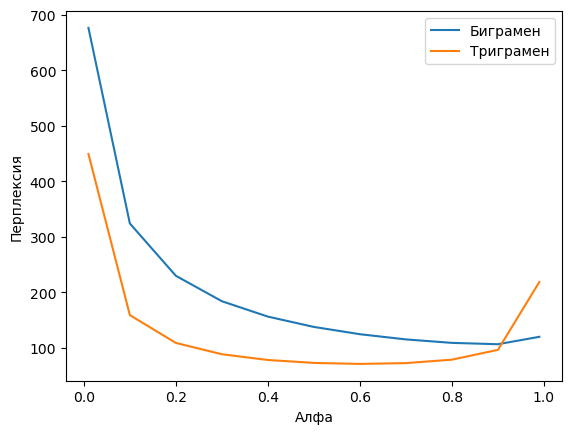

In [38]:
plt.plot(alpha,perp2)
plt.plot(alpha,perp3)
plt.ylabel('Перплексия')
plt.xlabel('Алфа')
plt.legend(['Биграмен','Триграмен'])
plt.show()

In [39]:
print('Перплексията на биграмния модел при алфа=0.9 върху dev е: '+str(M2.perplexity(devSentCorpus,0.9)))
print('Перплексията на биграмния модел при алфа=0.9 върху test е: '+str(M2.perplexity(testSentCorpus,0.9)))
print('Перплексията на триграмния модел при алфа=0.6 върху dev е: '+str(M3.perplexity(devSentCorpus,0.6)))
print('Перплексията на триграмния модел при алфа=0.6 върху test е: '+str(M3.perplexity(testSentCorpus,0.6)))

[                                                                                ]
[################################################################################]
Перплексията на биграмния модел при алфа=0.9 върху dev е: 106.64151786313651
[                                                                                ]
[################################################################################]
Перплексията на биграмния модел при алфа=0.9 върху test е: 105.78749995596347
[                                                                                ]
[################################################################################]
Перплексията на триграмния модел при алфа=0.6 върху dev е: 71.16768370833375
[                                                                                ]
[################################################################################]
Перплексията на триграмния модел при алфа=0.6 върху test е: 70.53497684764042


In [40]:
corpus1984 = [ [startToken] + [w.lower() for w in sent] + [endToken] for sent in PlaintextCorpusReader('.', '1984.txt').sents() ]
M3.perplexity(corpus1984,0.6)

[                                                                                ]
[################################################################################]


619.7633597771352

In [41]:
corpusNovinite = [ [startToken] + [w.lower() for w in sent] + [endToken] for sent in PlaintextCorpusReader('.', 'novinite.txt').sents() ]
M3.perplexity(corpusNovinite,0.6)

[                                                                                ]
[#####################################################################################################]


326.52856555710196